In [160]:
from sklearn.preprocessing import Normalizer,OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder

def processed_data(name, X, y):
    X_raw = X
    y_raw =y
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)

    # Preprocessing the data between 0 and 1
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X = scaler.transform(X)

    n_samples, n_features = X.shape
    n_targets = len(np.unique(y))
    
    return {
        'name':name,
        'X_raw': X_raw,
        'y_raw': y_raw,
        'X':X,
        'y':y,
        'X_train':X_train, 
        'X_test': X_test, 
        'y_train': y_train, 
        'y_test': y_test,
        'n_samples': n_samples,
        'n_features': n_features,
        'n_targets': n_targets
    }

# def credit_data():
#     data=np.genfromtxt('../dataset/german.data-numeric.txt') 
#     X,y = data[:,:-1], data[:,-1:].squeeze() 
#     return processed_data('credit-g',X, y)

# def banknote_data():
#     data=np.genfromtxt('../dataset/data_banknote_authentication.txt', delimiter=',') 
#     X,y = data[:,:-1], data[:,-1:].squeeze() 
#     return processed_data('banknote',X,y)

def credit_card_data():
    df = pd.read_csv("creditcard.csv")
    df = df.sample(frac=1)
    # amount of fraud classes 492 rows.
    fraud_df = df.loc[df['Class'] == 1]
    non_fraud_df = df.loc[df['Class'] == 0][:5000]
    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    fraud_data = normal_distributed_df.sample(frac=1, random_state=42)


    data = fraud_data.loc[:, fraud_data.columns != 'Class'] 
    target = fraud_data.loc[:, fraud_data.columns == 'Class'] 
    target = target.values
    target = np.reshape(target, (len(target)))
    return processed_data('Credit Card',data,target)
    
# def wine_data():
#     data=np.genfromtxt('../dataset/winequality.csv', delimiter=';')
#     X,y = data[:,:-1], data[:,-1:].squeeze()
#     return processed_data('wine-quality',X,y)

def breast_cancer_data():
    from sklearn.datasets import load_iris, load_breast_cancer
    data = load_breast_cancer()
    X,y = data.data, data.target
    return processed_data('Breast Cancer',X,y)


cdata = credit_card_data()
bdata = breast_cancer_data()

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.32
No. Iterations to Converge: 9
F1 Score:  0.85
Accuracy:  0.98     AUC:       0.87
Precision: 1.00     Recall:    0.74
*****************************************************


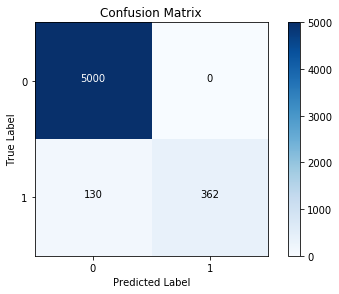

0.385023604339
Best cluster for Breast Cancer is: 2
0.293226050964
Best cluster for Credit Card is: 4


In [238]:
# # 3. Clustering

# ## k-Means Clustering

# This section will implement k-means clustering for both datasets. Our objectives are to:
# 1. Determine the best number of clusters for each dataset by using the elbow inspection method on silhouette score.
# 2. Describe the attributes which make up each cluster.
# 3. Score each cluster with an accuracy since technically we do have labels available for these datasets (labels are not used when determining clusters).
# 
# Since k-Means is susceptible to get stuck in local optima due to the random selection of initial cluster centers, I will report the average metrics over 5 models for each number of k clusters.

# In[9]:

import os
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier

from sklearn.externals.six import StringIO
from IPython.display import Image, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer,OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict, validation_curve 
def run_NN(data, target,preprocessor, name):
    kfold = KFold(n_splits=10,random_state=7)
    solver = MLPClassifier(activation='logistic', solver='adam')
    if(preprocessor==True):
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        cv_score_preprocess = cross_val_score(solver, data, target, cv = kfold)
        print "10 Fold Cross Validation Score with MinMax Scaler for", name, cv_score_preprocess.mean()
    else:
        cv_score_noPreProcess = cross_val_score(solver, data, target, cv = kfold)
        print "10 Fold Cross Validation Score without pre-processor for ",name, cv_score_noPreProcess.mean()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
def cluster_predictions(Y,clusterLabels):
    #print(Y, clusterLabels)
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

np.random.seed(0)

def run_kmeans(X,y,title):

    kclusters = list(np.arange(2,50,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; completeness_score = []; v_measure_score=[];
    adjusted_rand_score=[]; adjusted_mutual_info_score=[]; elbow =[]

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        sil_scores.append(sil_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y,km.labels_)
        
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, km.labels_))
        elbow.append(km.inertia_)
        
        completeness_score.append(metrics.completeness_score(y, km.labels_))
        v_measure_score.append(metrics.v_measure_score(y, km.labels_))
        adjusted_rand_score.append(metrics.adjusted_rand_score(y, km.labels_))
        adjusted_mutual_info_score.append(metrics.adjusted_mutual_info_score(y, km.labels_))
        

    # elbow curve for silhouette score
    fig = plt.figure()

    plt.plot(kclusters, sil_scores, label ='Avg SilhoutteScore')
    #plt.plot(kclusters, homo_scores, label ='Homogeneity Scores')
    #ax.plot(kclusters, completeness_score, label = 'Completeness Score')
    plt.plot(kclusters, v_measure_score, label='V measure score')
    plt.plot(kclusters, adjusted_rand_score, label='Adjusted random score')
    plt.plot(kclusters, adjusted_mutual_info_score, label = 'Adjusted mutual info score')
    #plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Scores')
    plt.title('Plot for KMeans: '+ title)
    plt.legend()
    plt.show()
    

   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, homo_scores)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('Homogeneity Score')
#     plt.title('Homogeneity Scores KMeans: '+ title)
#     plt.show()
    
#         # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, completeness_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('completeness_score')
#     plt.title('completeness_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('v_measure_score ')
#     plt.title('v_measure_score  KMeans: '+ title)
#     plt.show()
    
#             # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, adjusted_rand_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_rand_score')
#     plt.title('adjusted_rand_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_mutual_info_score ')
#     plt.title('adjusted_mutual_info_score  KMeans: '+ title)
#     plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores KMeans: '+ title)
#     plt.show()

    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('KMeans Training Time: '+ title)
    plt.show()
    
        # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, elbow)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('within cluster sum of squares')
    plt.title('Elbow curve: '+ title)
    plt.show()
    
def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()
    
def best_kmeans(X, y, num_cluster, data_name):
    best_cluster=0;
    accuracy=0;
    for i in range(2,num_cluster):
        km = KMeans(n_clusters=i,n_init=10,random_state=100,n_jobs=-1)
        km.fit(X,y)
        y_mode_vote=cluster_predictions(y,km.labels_)
        
        #a = accuracy_score(y,y_mode_vote)
        a= sil_score(X, km.labels_)

        #print(a,i)
        if(a>accuracy):
            accuracy=a
            best_cluster=i
    print(accuracy)
    print("Best cluster for %s is: %d"%(data_name, best_cluster))
    return best_cluster


# In[ ]:

# Initialize neural network object and fit object
# data = load_breast_cancer()
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, \
#                                                     test_size = 0.1, random_state = 3)

# # Normalize feature data
# scaler = MinMaxScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

#print(type(y_train))
#phishX,phishY,bankX,bankY = import_data()
#run_kmeans(cdata['X'], cdata['y'],cdata['name'])
km = KMeans(n_clusters=4,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,cdata['X'], cdata['y'])
#best_kmeans(X_train_scaled, y_train,10,'Breast Cancer Data')
best_kmeans(bdata['X'], bdata['y'],10,bdata['name'])
best_kmeans(cdata['X'], cdata['y'],10,cdata['name'])

# km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
# em = EM(n_components=2,n_init=10,random_state=100)
# em.fit(bdata['X'])
# sample=em.sample(5492)[0]
# sample=np.asarray(sample)
# print(sample.shape)
# print(km.fit_transform(cdata['X']).shape)

# run_NN(km.fit_transform(cdata['X']), cdata['y'],False, cdata['name']+ " after kmean with 2 clusters")
# run_NN(sample,  cdata['y'],False, cdata['name']+ " em with 2 components")

df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Phishing kMeans Cluster Centers.csv")

[ 0.14246535  0.31247886  0.15157985  0.07551703  0.34066805  0.2923747
  0.14964855  0.13131213  0.43535354  0.31486942  0.12275937  0.18493635
  0.12594826  0.03791198  0.19570316  0.25203533  0.08469697  0.2585717
  0.38214105  0.08371682  0.11702361  0.29104478  0.12093945  0.0499206
  0.34048767  0.21752966  0.15303514  0.27237113  0.27104278  0.136626  ]
[57 30]
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.00
No. Iterations to Converge: 5
Log-likelihood Lower Bound: 36.39
F1 Score:  0.94
Accuracy:  0.91     AUC:       0.88
Precision: 0.93     Recall:    0.95
*****************************************************


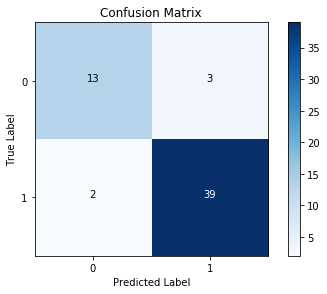

In [203]:
# ## Expectation Maximization

# This section will implement k-means clustering for both datasets. The same 3 objectives from k-means apply here.

# In[10]:


from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,100,5))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; completeness_score = []; v_measure_score=[];
    adjusted_rand_score=[]; adjusted_mutual_info_score=[]; aic_scores = []; bic_scores = []; elbow=[];
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        
        completeness_score.append(metrics.completeness_score(y, labels))
        v_measure_score.append(metrics.v_measure_score(y, labels))
        adjusted_rand_score.append(metrics.adjusted_rand_score(y, labels))
        adjusted_mutual_info_score.append(metrics.adjusted_mutual_info_score(y, labels))
        
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        #elbow.append(em.inertia_)
    
    plt.plot(kdist, sil_scores, label ='Avg SilhoutteScore')
    #plt.plot(kclusters, homo_scores, label ='Homogeneity Scores')
    #ax.plot(kclusters, completeness_score, label = 'Completeness Score')
    plt.plot(kdist, v_measure_score, label='V measure score')
    plt.plot(kdist, adjusted_rand_score, label='Adjusted random score')
    plt.plot(kdist, adjusted_mutual_info_score, label = 'Adjusted mutual info score')
    #plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Scores')
    plt.title('Plot for EM: '+ title)
    plt.legend()
    plt.show()
    
#     # plot model training time
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, elbow)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('within cluster sum of squares')
#     plt.title('Elbow curve: '+ title)
#     plt.show()
#     # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, sil_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('Avg Silhouette Score')
#     plt.title('Elbow Plot for EM: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, homo_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('Homogeneity Score')
#     plt.title('Homogeneity Scores EM: '+ title)
#     plt.show()
    
#             # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, completeness_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('completeness_score')
#     plt.title('completeness_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('v_measure_score ')
#     plt.title('v_measure_score  KMeans: '+ title)
#     plt.show()
    
#             # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, adjusted_rand_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_rand_score')
#     plt.title('adjusted_rand_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_mutual_info_score ')
#     plt.title('adjusted_mutual_info_score  KMeans: '+ title)
#     plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores EM: '+ title)
#     plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
        # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('EM Training Time: '+ title)
    plt.show()
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    #print(X[0])
    sample=em.sample(57)[0]
    sample=np.asarray(sample.shape)
    print(sample)
    y_mode_vote = cluster_predictions(y,labels)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()
def best_em(X, y, num_cluster, data_name):
    best_cluster=0;
    accuracy=0;
    for i in range(2,num_cluster):
        em = EM(n_components=i,n_init=10,random_state=100)
        em.fit(X,y)
        labels = em.predict(X)
        a= sil_score(X, labels)
        #print(a,i)
        if(a>accuracy):
            accuracy=a
            best_cluster=i
    print("Best cluster for %s is: %d"%(data_name, best_cluster))
    return best_cluster

#run_EM(X_train_scaled,y_train,'Breast Cancer Data')
em = EM(n_components=4,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,X_test_scaled,y_test)
#best_em(bdata['X'], bdata['y'],10,bdata['name'])
#best_em(cdata['X'], cdata['y'],10,cdata['name'])
df = pd.DataFrame(em.means_)
df.to_csv("Phishing EM Component Means.csv")


# In[ ]:


# phishX,phishY,bankX,bankY = import_data()
# X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.25)
# run_EM(X_train,y_train,'Banking Data')
# em = EM(n_components=41,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
# evaluate_EM(em,bankX,bankY)
# df = pd.DataFrame(em.means_)
# df.to_csv("Banking EM Component Means.csv")

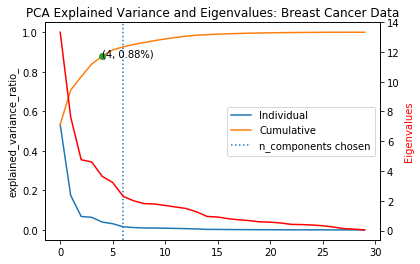

In [116]:
def pca_n_components(X, y, dataset_name, n_components=[]):
    decision_tree = DecisionTreeClassifier()
    np.random.seed(5)

    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca),('decision_tree',decision_tree)])

    # Plot the PCA spectrum
    pca.fit(X)

    fig, ax1 = plt.subplots()
    ax1.plot(pca.explained_variance_ratio_, label="Individual")
    ax1.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
    ax1.set_ylabel('explained_variance_ratio_')

    cr = np.cumsum(pca.explained_variance_ratio_)
    cr_85_x = np.argmax(cr>0.84)
    cr_85_y = cr[cr_85_x]
    ax1.plot(cr_85_x, cr_85_y, marker='o')
    ax1.annotate("(%i, %0.2f%%)"%(cr_85_x, cr_85_y),xy=(cr_85_x, cr_85_y))

    ax2 = ax1.twinx()
    ax2.plot(pca.singular_values_, 'r-', label="Eigenvalues") #eigenvalues
    ax2.set_ylabel('Eigenvalues', color='r')


    plt.xlabel('n_components')
    plt.title("PCA Explained Variance and Eigenvalues: "+ dataset_name)


    # Prediction
    if n_components:
        estimator =  GridSearchCV(pipe,dict(pca__n_components=n_components))
        estimator.fit(X, y)
        ax1.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
                    linestyle=':', label='n_components chosen')
        
    ax1.legend(loc="best")
    plt.show()

pca_n_components(X_train_scaled,y_train,'Breast Cancer Data', [2,3,4,5,6,7])


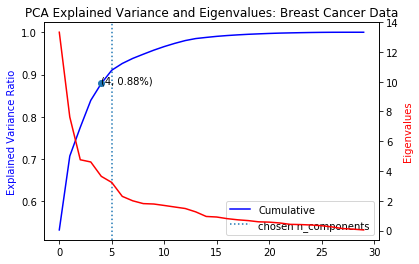

(512L, 5L)
10 Fold Cross Validation Score without pre-processor for  Breast Cancer Data after PCA and kmean with 2 clusters 0.92963800905
10 Fold Cross Validation Score without pre-processor for  Breast Cancer Data after PCA and em with 2 components 0.617307692308


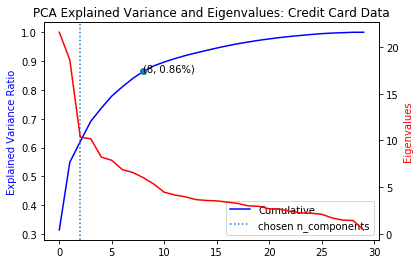

(512L, 2L)
10 Fold Cross Validation Score without pre-processor for  Credit Card Data after PCA and kmean with 2 clusters 0.931561085973
10 Fold Cross Validation Score without pre-processor for  Credit Card Data after PCA and em with 2 components 0.617307692308


In [209]:
def pca_n_components(X, y, dataset_name, n_components=[]):
    decision_tree = DecisionTreeClassifier()
    np.random.seed(5)

    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca),('decision_tree',decision_tree)])

    # Plot the PCA spectrum
    pca.fit(X)

    fig, ax1 = plt.subplots()
    #ax1.plot(pca.explained_variance_ratio_, label="Individual")
    ax1.plot(np.cumsum(pca.explained_variance_ratio_), 'b-', label="Cumulative")
    ax1.set_ylabel('Explained Variance Ratio', color='b')

    cr = np.cumsum(pca.explained_variance_ratio_)
    cr_85_x = np.argmax(cr>0.84)
    cr_85_y = cr[cr_85_x]
    ax1.plot(cr_85_x, cr_85_y, marker='o')
    ax1.annotate("(%i, %0.2f%%)"%(cr_85_x, cr_85_y),xy=(cr_85_x, cr_85_y))

    ax2 = ax1.twinx()
    ax2.plot(pca.singular_values_, 'r-', label="Eigenvalues") #eigenvalues
    ax2.set_ylabel('Eigenvalues', color='r')


    plt.xlabel('n_components')
    plt.title("PCA Explained Variance and Eigenvalues: "+ dataset_name)


    # Prediction
    if n_components:
        estimator =  GridSearchCV(pipe,dict(pca__n_components=n_components))
        estimator.fit(X, y)
        ax1.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
                    linestyle=':', label='chosen n_components')
        
    ax1.legend(loc="best")
    plt.show()
    
    pca_new = PCA(n_components = estimator.best_estimator_.named_steps['pca'].n_components)
    pca_new.fit(X_train_scaled)
    X_train_transformed = pca_new.transform(X_train_scaled)
    X_test_transformed = pca_new.transform(X_test_scaled)
    
    km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
    em = EM(n_components=2,n_init=10,random_state=100)
    em.fit(X_train_transformed)

    sample=em.sample(512)[0]
    sample=np.asarray(sample)
    print(sample.shape)

    run_NN(km.fit_transform(X_train_transformed), y_train,False, dataset_name+ " after PCA and kmean with 2 clusters")
    
    run_NN(sample, y_train,False, dataset_name+ " after PCA and em with 2 components")

    
    
    
#     print(X_train_transformed.shape, X_train_scaled.shape)
#     run_kmeans(X_train_transformed,y_train,dataset_name)
#     km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
#     evaluate_kmeans(km,X_test_transformed,y_test)
    
#     run_EM(X_train_transformed,y_train,dataset_name)
#     em = EM(covariance_type='diag',n_init=1,warm_start=True,random_state=100)
#     evaluate_EM(em,X_test_transformed,y_test)
    

pca_n_components(X_train_scaled,y_train,'Breast Cancer Data', [2,3,4,5])
pca_n_components(cdata['X'],cdata['y'],'Credit Card Data', [2,3,4,5])


NameError: name 'gridSearch' is not defined

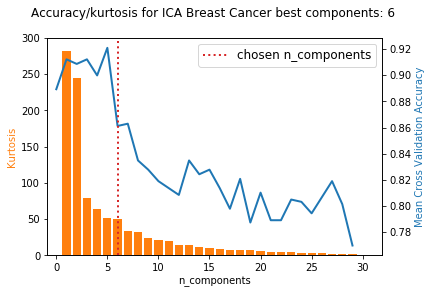

(512L, 6L)
10 Fold Cross Validation Score without pre-processor for  Breast Cancer after ICA and kmean with 2 clusters 0.617307692308
10 Fold Cross Validation Score without pre-processor for  Breast Cancer after ICA and em with 2 components 0.617307692308


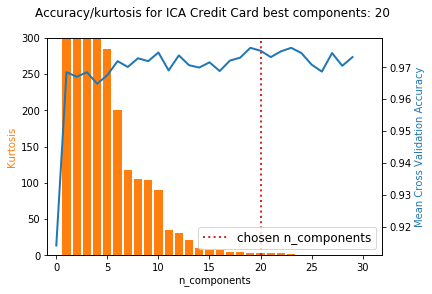

(512L, 20L)
10 Fold Cross Validation Score without pre-processor for  Credit Card after ICA and kmean with 2 clusters 0.625150829563
10 Fold Cross Validation Score without pre-processor for  Credit Card after ICA and em with 2 components 0.617307692308


In [246]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
import scipy


def kurtosis(X, ica):
    transformed = ica.transform(X)
    kurtosis = scipy.stats.kurtosis(transformed)
    kurtosis = sorted(kurtosis, reverse = True)
#     kurtosis = MinMaxScaler(feature_range=(0,10))
    return kurtosis

def ica_n_components(data):
    np.random.seed(5)
    n_components = data['n_features']
    n_components_range = list(range(1,n_components+1))
    decision_tree = DecisionTreeClassifier()
    ica = FastICA(n_components=n_components)
    pipe = Pipeline(steps=[('ica', ica), ('decisionTree', decision_tree)])
    # Plot the ICA spectrum
    ica.fit(data['X'])

    fig, ax = plt.subplots()
    _kurt = kurtosis(data['X'],ica)
    ax.bar(n_components_range, _kurt,color="C1")
    plt.axis('tight')
    plt.xlabel('n_components')
    ax.set_ylim(bottom=0,top=300)
    ax.set_ylabel('Kurtosis', color='C1')

    gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components_range), cv = 3)
    gridSearch.fit(data['X'],data['y'])
    results = gridSearch.cv_results_
    ax1 = ax.twinx()

    #Plotting the accuracies and best component
    ax1.plot(results['mean_test_score'], linewidth = 2, color = 'C0')
    ax1.set_ylabel('Mean Cross Validation Accuracy', color='C0')
    best_n = gridSearch.best_estimator_.named_steps['ica'].n_components
    ax1.axvline(best_n, linestyle=':', label='chosen n_components', linewidth = 2, color="C3")

    plt.legend(prop=dict(size=12))
    plt.title('Accuracy/kurtosis for ICA %s best components: %d \n '%(data['name'], best_n ))
    plt.show()
    
    
    pca_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
    pca_new.fit(X_train_scaled)
    X_train_transformed = pca_new.transform(X_train_scaled)
    X_test_transformed = pca_new.transform(X_test_scaled)
    
    #run_NN(X_train_transformed, y_train,False, data['name']+ " after ICA")
    km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
    em = EM(n_components=2,n_init=10,random_state=100)
    em.fit(X_train_transformed)

    sample=em.sample(512)[0]
    sample=np.asarray(sample)
    print(sample.shape)

    run_NN(km.fit_transform(X_train_transformed), y_train,False, data['name'] + " after ICA and kmean with 2 clusters")
    
    run_NN(sample, y_train,False, data['name'] + " after ICA and em with 2 components")
#     print(X_train_transformed.shape, X_train_scaled.shape)
#     run_kmeans(X_train_transformed,y_train,data['name'])
#     km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
#     evaluate_kmeans(km,X_test_transformed,y_test)
    
#     run_EM(X_train_transformed,y_train,data['name'])
#     em = EM(covariance_type='diag',n_init=1,warm_start=True,random_state=100)
#     evaluate_EM(em,X_test_transformed,y_test)
    
ica_n_components(bdata)
ica_n_components(cdata)

C:\Users\rosha\Anaconda2\envs\skLearn\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


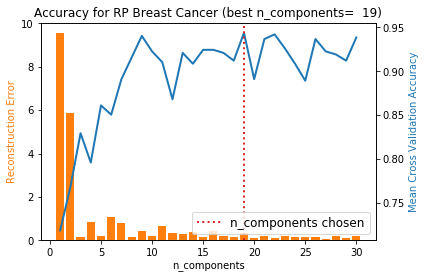

10 Fold Cross Validation Score without pre-processor for  Breast Cancer after RP 0.954977375566


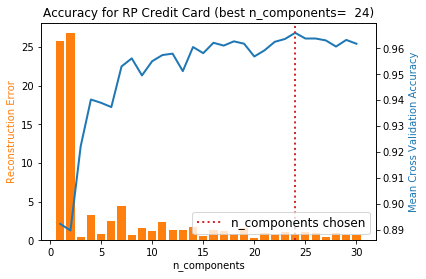

10 Fold Cross Validation Score without pre-processor for  Credit Card after RP 0.947171945701


In [234]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.random_projection import GaussianRandomProjection
import scipy
from numpy import linalg as LA


def reconstruction_errors(X, n_components):
    _metrics = []
    for i in n_components:
        rp = GaussianRandomProjection(n_components=i)
        transformed = rp.fit_transform(X)
        inverse = transformed.dot(rp.components_) + np.mean(X, axis = 0)
        _error = ((X - inverse)**2).mean()
        _mse = np.sum(np.square(X - inverse))/inverse.size
        _total_loss = LA.norm((X - inverse),None)
        _metrics.append({
            'error': _error,
#             'total_loss': _total_loss,
#             'mse': _mse
        })
    df = pd.DataFrame(_metrics)
    return df['error'].values

def n_componets_rp(data):
    np.random.seed(5)
    X = data['X']
    y = data['y']
    dataset_name = data['name']
    n_components = data['n_features']
    n_components_range = list(range(1,n_components+1))

    rp = GaussianRandomProjection(n_components=n_components)
    rp.fit(X)

    decision_tree = DecisionTreeClassifier()
    pipe = Pipeline(steps=[('rp', rp), ('decisionTree', decision_tree)])

    fig, ax = plt.subplots()
    _reconstruction_error = reconstruction_errors(X, n_components_range)
    ax.bar(n_components_range, _reconstruction_error, color='C1')
    plt.axis('tight')
    plt.xlabel('n_components')
    ax.set_ylabel('Reconstruction Error', color='C1')
    
    gridSearch = GridSearchCV(pipe, dict(rp__n_components=n_components_range), cv = 3)
    gridSearch.fit(X, y)
    results = gridSearch.cv_results_

    #Plotting the accuracies and best component
    ax1 = ax.twinx()
    ax1.plot(n_components_range, results['mean_test_score'], linewidth = 2, color = 'C0')
    ax1.set_ylabel('Mean Cross Validation Accuracy', color='C0')
    ax1.set_xlabel('n_components')
    best_n_component = gridSearch.best_estimator_.named_steps['rp'].n_components
    ax1.axvline(best_n_component, linestyle=':', label='n_components chosen', linewidth = 2, color='C3')

    plt.legend(prop=dict(size=12))
    plt.title('Accuracy for RP %s (best n_components=  %d)'%(dataset_name, best_n_component ))
    plt.show()
    
    pca_new = GaussianRandomProjection(n_components = gridSearch.best_estimator_.named_steps['rp'].n_components)
    pca_new.fit(X_train_scaled)
    X_train_transformed = pca_new.transform(X_train_scaled)
    X_test_transformed = pca_new.transform(X_test_scaled)
    
    run_NN(X_train_transformed, y_train,False, data['name']+ " after RP")

    
#     print(X_train_transformed.shape, X_train_scaled.shape)
#     run_kmeans(X_train_transformed,y_train,data['name'])
#     km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
#     evaluate_kmeans(km,X_test_transformed,y_test)
    
#     run_EM(X_train_transformed,y_train,data['name'])
#     em = EM(covariance_type='diag',n_init=1,warm_start=True,random_state=100)
#     evaluate_EM(em,X_test_transformed,y_test)
    
n_componets_rp(bdata)
n_componets_rp(cdata)


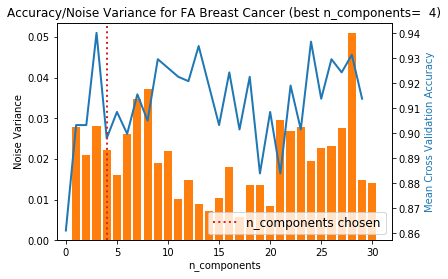

10 Fold Cross Validation Score without pre-processor for  Breast Cancer after FA 0.947209653092


C:\Users\rosha\Anaconda2\envs\skLearn\lib\site-packages\sklearn\decomposition\factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


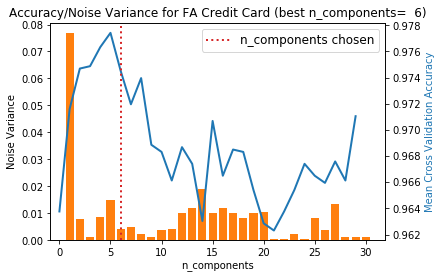

10 Fold Cross Validation Score without pre-processor for  Credit Card after FA 0.962858220211


In [134]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import FactorAnalysis
from sklearn.datasets import load_digits

def n_components_fa(data):
    np.random.seed(5)
    n_components = data['n_features']
    n_components_range = list(range(1,n_components+1))

    # Create and Run FA
    fa = FactorAnalysis()
    fa.fit(data['X'])

    # Create Pipeline and Find the best n
    decision_tree = DecisionTreeClassifier()
    pipe = Pipeline(steps=[('fa', fa), ('decision_tree', decision_tree)])
    estimator = GridSearchCV(pipe, dict(fa__n_components=n_components_range), cv = 3)
    estimator.fit(data['X'], data['y'])
    results = estimator.cv_results_
    best_n = estimator.best_estimator_.named_steps['fa'].n_components

    fig, ax = plt.subplots()
    ax.bar(n_components_range, fa.noise_variance_, color='C1')
    plt.axis('tight')
    plt.xlabel('n_components')
    ax.set_ylabel('Noise Variance')

    ax1 = ax.twinx()

    #Plotting the accuracies and best component
    ax1.plot(results['mean_test_score'], linewidth=2, color='C0')
    ax1.set_ylabel('Mean Cross Validation Accuracy', color='C0')

    ax1.axvline(best_n, linestyle=':', label='n_components chosen', linewidth = 2, color='C3')

    plt.legend(prop=dict(size=12))
    plt.title('Accuracy/Noise Variance for FA %s (best n_components=  %d)'%(data['name'],best_n ))
    plt.show()
    
    pca_new = FactorAnalysis(n_components = estimator.best_estimator_.named_steps['fa'].n_components)
    pca_new.fit(X_train_scaled)
    X_train_transformed = pca_new.transform(X_train_scaled)
    X_test_transformed = pca_new.transform(X_test_scaled)
    
    #run_NN(X_train_transformed, y_train,False, data['name']+ " after FA")

    
#     print(X_train_transformed.shape, X_train_scaled.shape)
#     run_kmeans(X_train_transformed,y_train,data['name'])
#     km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
#     evaluate_kmeans(km,X_test_transformed,y_test)
    
#     run_EM(X_train_transformed,y_train,data['name'])
#     em = EM(covariance_type='diag',n_init=1,warm_start=True,random_state=100)
#     evaluate_EM(em,X_test_transformed,y_test)
    
    
n_components_fa(bdata)
n_components_fa(cdata)